# IAA016 - Tópicos em IA
# Aluno: Mateus Cichelero da Silva

## Exercício - Caixeiro Viajante com Algoritmos Genéticos
Março 2023

In [36]:
import random
import matplotlib.pyplot as plt
import math
import itertools
from random import choices
import numpy

In [37]:
def gera_cidades(n): 
    """Gera endereço das n cidades - coord x e y e nomes de 1 a 100
       entrada: n - numero de cidades a serem geradas
       saida: cidades - dicionario no formato {nome_cidade: {"x": valor coordenada x,
                                                             "y": valor coordenada y}}
    """ 
    n = 100
    coord_cidades = []
    for i in range(n):
        coord_cidades.append([random.randint(0,100),random.randint(0,100)])

    cidades = {}
    for i in range(n):
        cidades[i+1] = {"x" : coord_cidades[i][0] , "y" :coord_cidades[i][1]}
    return cidades


def populacaoInicial(tamanho):
    """Gera população inicial de individuos
       entrada: tamanho - quantidade de percursos a fazerem parte da populacao
       saida: resultado - lista contendo 'tamanho' percursos com cidades embaralhadas
    """
    resultado = []
    lista_cidades = [i+1 for i in range(100)]
    for a in range(tamanho):
        #embaralha aleatoriamente lista de 1 a 100
        resultado.append(random.sample(lista_cidades, len(lista_cidades))) 
    return resultado


def calcula_distancia(x1,y1, x2,y2):
    """Calcula distancia entre dois pontos cartesianos
       entradas: x1,y1,x2,y2 - coordenadas de dois pontos no plano
       saida: dist - float representando a distancia entre pontos
    """
    a = x2 - x1
    b = y2 - y1
    dist = math.sqrt(math.pow(a, 2) + math.pow(b, 2))
    return dist 


def avaliacao(populacao, cidades):
    """Realiza avaliacao de metrica fitness para percursos gerados
      entradas: populacao - conjunto de percursos a serem avaliados
                cidades - informacao sobre coordenadas das cidades no mapa
      saida: fit - para cada percurso, representa o inverso da distancia total 
      (incluindo ultima viagem de retorno a posicao inicial)
    """
    fit = []
    for percurso in populacao:
        dist_percurso = 0
        for i in range(100):
            if i == 99: #ultima posição soma a distancia da ultima cidade com a primeira
                dist_percurso += calcula_distancia(cidades[percurso[i]]["x"],
                                                   cidades[percurso[i]]["y"],
                                                   cidades[percurso[0]]["x"],
                                                   cidades[percurso[0]]["y"])
            else:    
                dist_percurso += calcula_distancia(cidades[percurso[i]]["x"],
                                                   cidades[percurso[i]]["y"],
                                                   cidades[percurso[i+1]]["x"],
                                                   cidades[percurso[i+1]]["y"])
      
        fit.append(round(1/dist_percurso, 8))
    return fit;


def plota_percurso(percurso, texto, cidades):
    """Gera imagem representando percurso percorrido
       entradas: percurso - lista de cidades representando percurso
                 texto - texto informando geracao e fitness
                 cidades - coordenadas das cidades no plano
    """
    x= [cidades[cidade]["x"] for cidade in percurso]
    y= [cidades[cidade]["y"] for cidade in percurso]
    plt.rcParams['figure.figsize'] = [6, 6]

    fig, ax = plt.subplots()
    ax.scatter(x, y, color="Red")
    ax.plot(x, y, color="#1f77b4")
    plt.title(f'CAIXEIRO VIAJANTE - {texto}')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')

    for i, txt in enumerate(percurso):
        ax.annotate(txt, (x[i], y[i]))

    ax.plot([x[-1],x[0]],[y[-1],y[0]], color="#1f77b4")
    path = str(texto).replace(" ", "_")
    plt.savefig(f"{path}.png")
    plt.show()

def selecao(pop, n, cidades):
    """Realiza seleção dos n melhores percursos (a partir do ranking de fitness) para proxima geração
       entradas: pop - percursos da geração a serem selecionados
                 n - numero de n melhores percursos selecionados
                 cidades - coordenadas das cidades no plano
      saida: pop_selecionada - lista de percursos selecionados
    """
    rank_fit = avaliacao(pop, cidades)
    indexes_selecionados = numpy.argsort(rank_fit)[::-1][:n]
    pop_selecionada = []
    for index in indexes_selecionados:
        pop_selecionada.append(pop[index])
    return pop_selecionada #primeira posicao de retorno é o primeiro do ranking


def cruza_dois_individuos(a,b): 
    """Cruza dois individuos a partir da divisao em um unico ponto
       entradas: a,b - percursos a serem cruzados
       saida: f1_, f2_ - percursos filhos do cruzamento, tratados para evitar cidades duplicatas
    """
    lista_cidades = [i+1 for i in range(100)]
    corte = random.randint(2,8)
    f1 = a[:corte] + b[corte:]
    f2 = b[:corte] + a[corte:]
    # aplica tratamento para lidar com cidades repetidas pos cruzamento
    f1_ = sorted(set(f1), key=f1.index) + list(set(lista_cidades) - set(f1))
    f2_ = sorted(set(f2), key=f2.index) + list(set(lista_cidades) - set(f2))
    return [f1_, f2_]


def mutacao(pop, tx_mutacao): 
    """Realiza mutacao nos percursos, trocando a posição de duas cidades aleatoriamente
       entradas: pop - populacao de percursos a serem mutados
                 tx_mutacao - a cada 100 percursos, quantos serao selecionados para aplicar mutação
       saida: pop_mutada - conjunto final de percursos após mutação
    """
    pop_mutada = []
    pool_posicoes = [i for i in range(100)]
    for cidades in pop: #percorre todos os individuos na fase final de mutacao
        if random.randint(1,100) <= tx_mutacao: #testa com taxa de mutacao
            posicoes = random.sample(pool_posicoes, 2) #sorteando posicoes a serem trocadas
            cidades[posicoes[0]], cidades[posicoes[1]] = cidades[posicoes[1]], cidades[posicoes[0]]
        pop_mutada.append(cidades)
    return pop_mutada


def cruzamento_roleta(pop, tx_cruzamento, cidades):
    """Seleciona restante da populacao para cruzamento, atraves do mecanismo de roleta com pesos
    para seleção proporcionais ao fitness do percurso
       entradas: pop - população a ser considerada para cruzamento
                 tx_cruzamento - a cada 100 pais, quanto gerarão filhos através do cruzamento
                 cidades - coordenadas das cidades no plano
       saida: new_pop - população de percursos filhos a fazerem parte da geração
    """
    new_pop = []
    rank_fit = avaliacao(pop, cidades)
    while len(new_pop) < 50:
        pais = tuple(choices(pop, weights=rank_fit, k=2))
        if random.randint(1,100) <= tx_cruzamento:
            new_pop.extend(cruza_dois_individuos(pais[0], pais[1]))
    
    return new_pop

In [38]:
def main():
    """Função principal.
    Controla fluxo para aplicação do algoritmo genético para o problema do caixeiro viajante.
    """

    #gera dict de cidades e seus enderecos
    cidades = gera_cidades(100)
    #gera população inicial
    pop = populacaoInicial(100)

    #gera primeiro plot da menor distancia para populacao inicial aleatoria
    rank_fit = avaliacao(pop, cidades)
    max_value = max(rank_fit)
    max_index = rank_fit.index(max_value)
    print("##################################################################")
    print(f"VALOR MAXIMO FITNESS PARA GERAÇÃO 0: {max_value}")
    print("PERCURSO GERAÇÃO 0:")
    plota_percurso(pop[max_index], f"GERAÇÃO 0 FITNESS {max_value}", cidades)


    geracoes = 1
    while geracoes <=8000: #8 mil gerações
        pop_geracao = []
        ##seleção
        pop_selecionada = selecao(pop, n=50, cidades=cidades)
        pop_geracao.extend(pop_selecionada)
        ##cruzamento
        filhos = cruzamento_roleta(pop, tx_cruzamento = 60, cidades=cidades)
        pop_geracao.extend(filhos)
        ##mutação
        pop_geracao = mutacao(pop_geracao, tx_mutacao = 5)

        if geracoes%1000 == 0:
        ##avaliação
            rank_fit = avaliacao(pop_geracao, cidades)
            max_value = max(rank_fit)
            max_index = rank_fit.index(max_value)
            print("##################################################################")
            print(f"VALOR MAXIMO FITNESS PARA GERAÇÃO {geracoes}: {max_value}")
            print(f"PERCURSO GERAÇÃO {geracoes}:")
            plota_percurso(pop_geracao[max_index], f"GERAÇÃO {geracoes} FITNESS {max_value}", cidades)


        geracoes += 1
        pop = pop_geracao
    
    print("Melhor percurso da última geração:")
    print(pop_geracao[max_index])


##################################################################
VALOR MAXIMO FITNESS PARA GERAÇÃO 0: 0.00022057
PERCURSO GERAÇÃO 0:


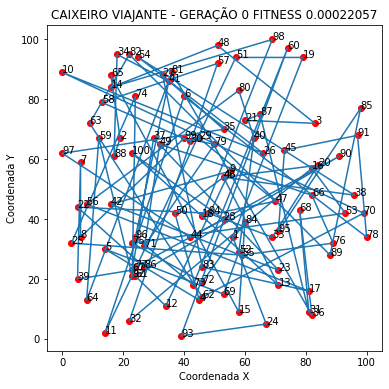

##################################################################
VALOR MAXIMO FITNESS PARA GERAÇÃO 1000: 0.00054872
PERCURSO GERAÇÃO 1000:


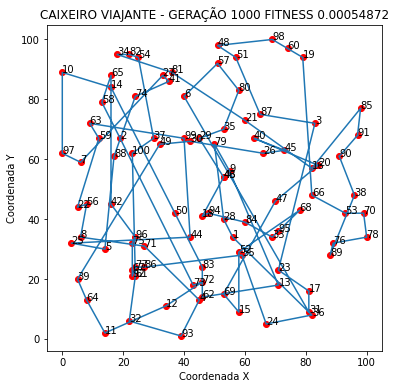

##################################################################
VALOR MAXIMO FITNESS PARA GERAÇÃO 2000: 0.00065608
PERCURSO GERAÇÃO 2000:


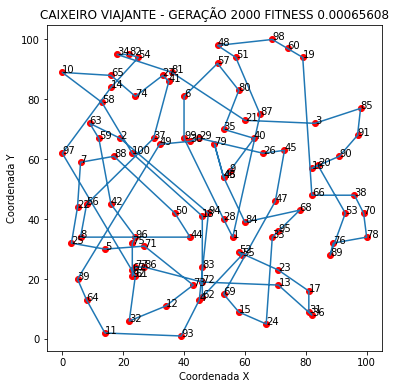

##################################################################
VALOR MAXIMO FITNESS PARA GERAÇÃO 3000: 0.00068799
PERCURSO GERAÇÃO 3000:


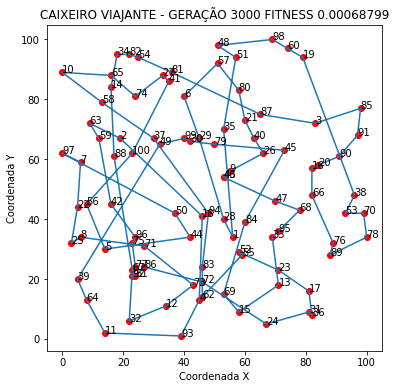

##################################################################
VALOR MAXIMO FITNESS PARA GERAÇÃO 4000: 0.00072947
PERCURSO GERAÇÃO 4000:


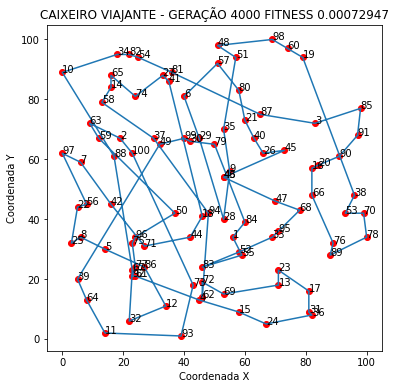

##################################################################
VALOR MAXIMO FITNESS PARA GERAÇÃO 5000: 0.00077758
PERCURSO GERAÇÃO 5000:


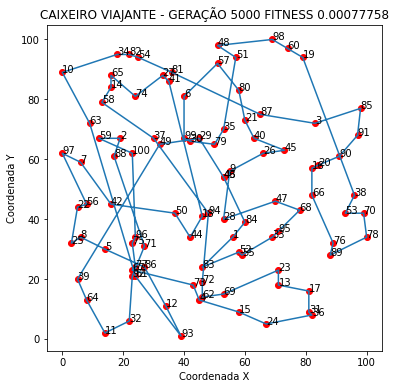

##################################################################
VALOR MAXIMO FITNESS PARA GERAÇÃO 6000: 0.00079022
PERCURSO GERAÇÃO 6000:


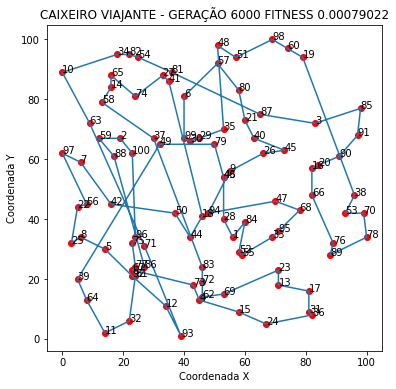

##################################################################
VALOR MAXIMO FITNESS PARA GERAÇÃO 7000: 0.00079902
PERCURSO GERAÇÃO 7000:


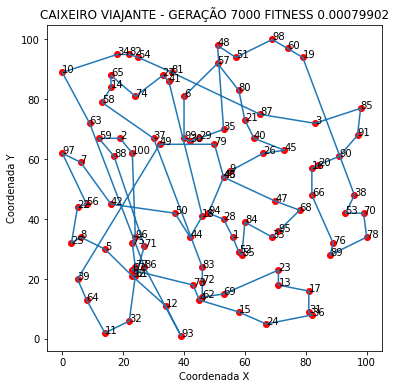

##################################################################
VALOR MAXIMO FITNESS PARA GERAÇÃO 8000: 0.00082381
PERCURSO GERAÇÃO 8000:


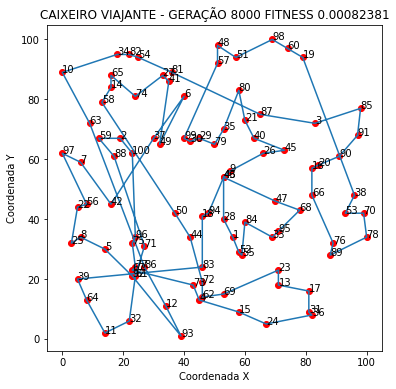

Melhor percurso da última geração:
[91, 85, 3, 87, 81, 54, 82, 34, 10, 63, 86, 12, 93, 92, 5, 8, 25, 22, 56, 97, 7, 42, 37, 6, 49, 41, 27, 74, 65, 14, 58, 50, 44, 72, 62, 69, 23, 13, 17, 31, 36, 24, 15, 4, 73, 67, 77, 75, 96, 100, 2, 59, 88, 71, 61, 32, 11, 64, 39, 83, 18, 94, 46, 28, 1, 52, 55, 84, 33, 95, 68, 47, 43, 9, 26, 45, 40, 21, 80, 35, 79, 29, 30, 99, 57, 48, 51, 98, 60, 19, 38, 53, 70, 78, 89, 76, 66, 16, 20, 90]


In [39]:
if __name__ == "__main__":
    main()